# Integrating GPT4 + SoM + Owlv2

In [1]:
import sys
import os
import torch
from PIL import Image

current_dir = os.getcwd()
# Navigate up one directory to get the correct path
sys.path.insert(0, os.path.abspath(os.path.join(current_dir, "..", "src")))

from mllm_module import gpt4v_completion, gpt4v_completion_async, ImageTextConversation, Message
from detection_module.owlv2 import Owlv2
from detection_module.utils import class_agnostic_nms, show_images
import instructor # IMPORTANT :Please install instructor version 1.3.1

ModuleNotFoundError: No module named 'torch'

## Image Visualization

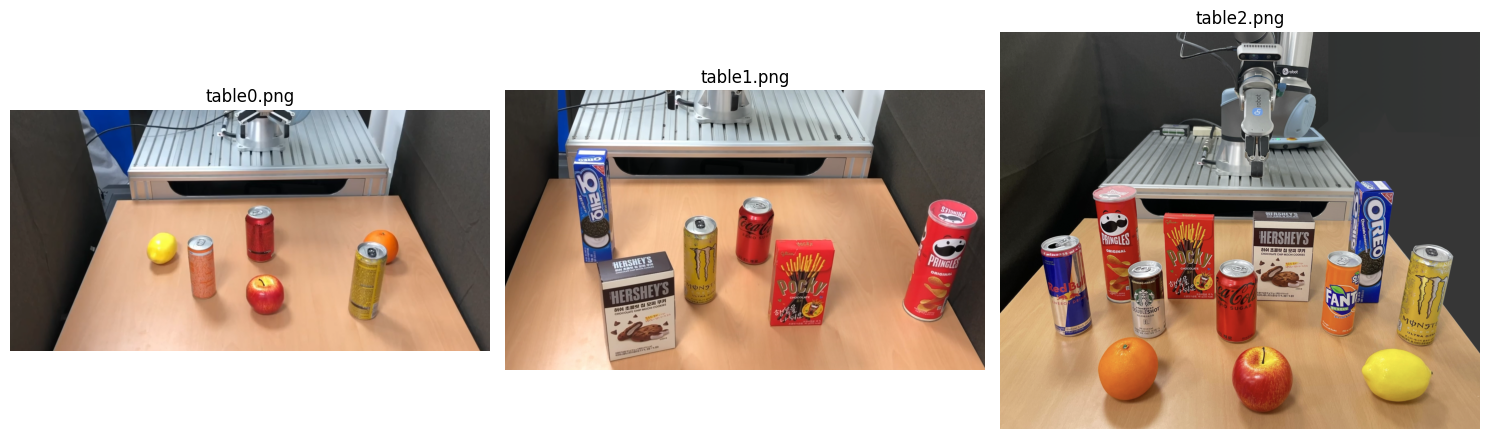

In [2]:
image_dir = "../data/images"
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
image_paths = sorted(image_paths)
images = [Image.open(img).convert("RGB") for img in image_paths]
titles = [os.path.basename(img_path) for img_path in image_paths]

# Show images using the utility function
show_images(images, titles)

## Step 1 (Detect Object with `Owlv2`)

+ Inference with owlv2 to get objects (we don't care about it's label gpt4 will label it)

In [3]:
object_prior = ["a can", "a box", "a fruite", "an orange", "an apple", "a lemon"]

samples = {
    'table0': {
        'image': images[0],
        'text': object_prior,
    },
    'table1': {
        'image': images[1],
        'text': object_prior,
    },
    'table2': {
        'image': images[2],
        'text': object_prior,
    },
}

In [4]:
# load model 
owlvit = Owlv2()

detection_results = []
for sample in samples.values():
    # inference
    sample['box_threshold'] = 0.15 # lower the value to detect more objects
    result = owlvit.detect_objects(**sample)[0]
    detection_results.append(result)

Since Huggingface's `owlvit` and `owlv2` do not support NMS, we need to implement custom NMS.

In [5]:
# nms
detection_results = class_agnostic_nms(detection_results, iou_threshold=0.5)

In [6]:
import sys
import os
import torch
from PIL import Image

current_dir = os.getcwd()
# Navigate up one directory to get the correct path
sys.path.insert(0, os.path.abspath(os.path.join(current_dir, "..", "src")))

from mllm_module import gpt4v_completion, gpt4v_completion_async, ImageTextConversation, Message
from detection_module.owlv2 import Owlv2
from detection_module.utils import calculate_iou, show_images
import instructor # IMPORTANT :Please install instructor version 1.3.1

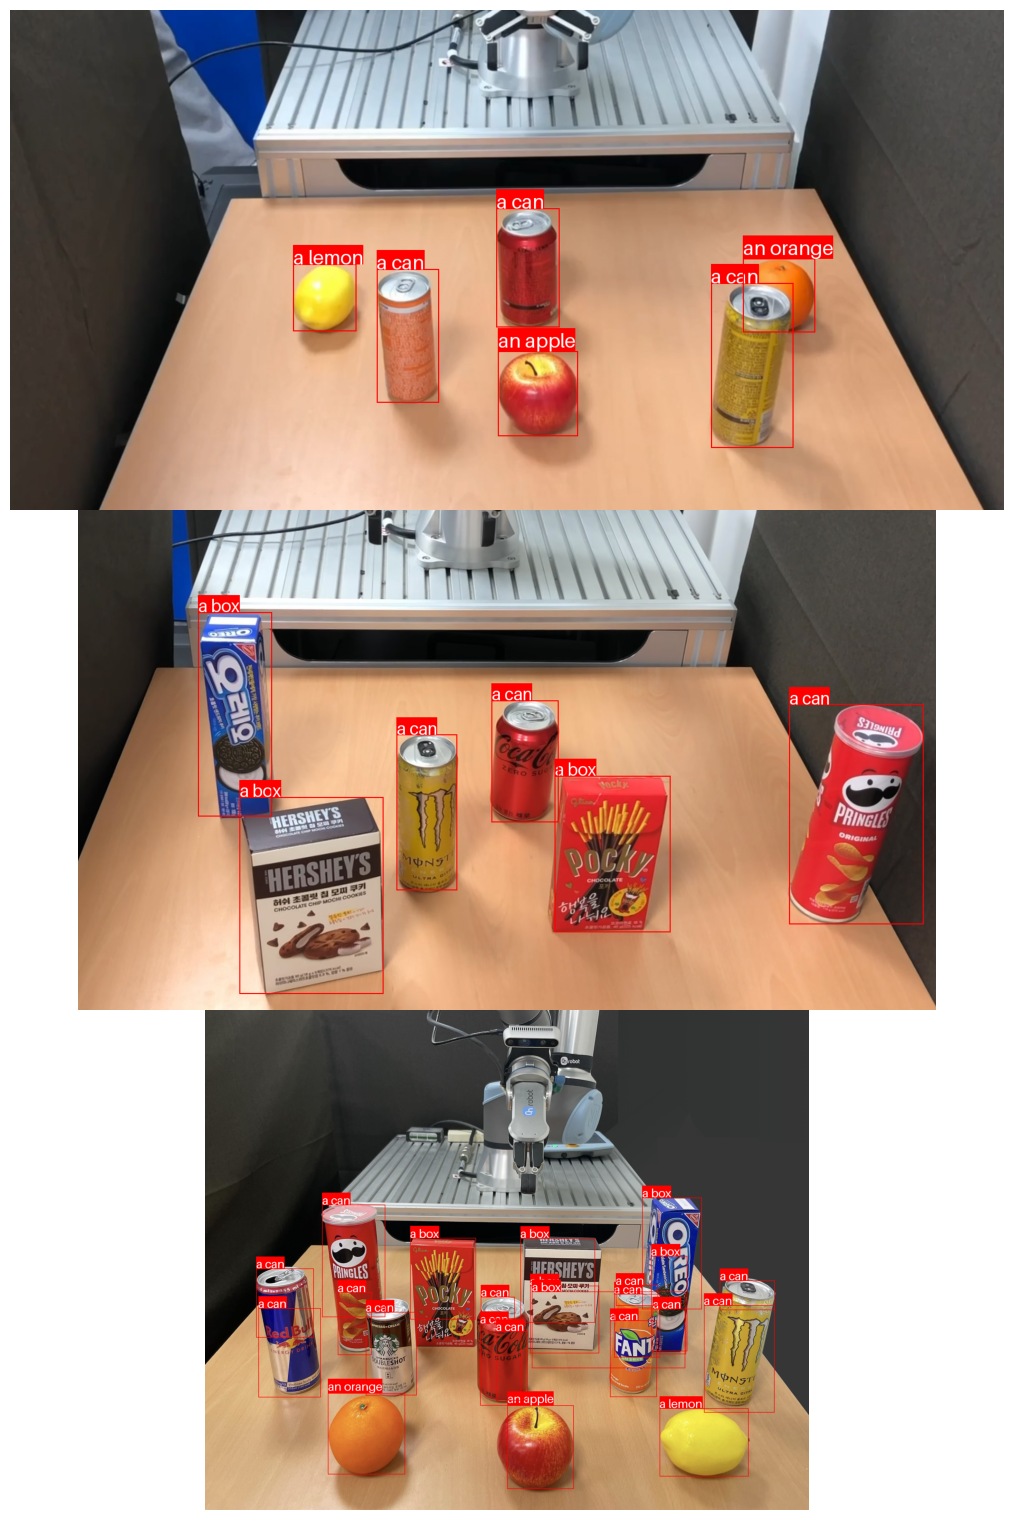

In [7]:
import matplotlib.pyplot as plt

def show_images_with_bboxes(images, detection_results):
    fig, axs = plt.subplots(len(images), 1, figsize=(10, len(images) * 5))
    
    for ax, img, result, sample in zip(axs, images, detection_results, samples.values()):
        img = img.copy()

        boxes = result['boxes']
        labels = [sample['text'][idx] for idx in result['labels'].tolist()]
        img = owlvit.draw_boxes(img, boxes, labels)

        ax.imshow(img)
        ax.axis('off')

    plt.subplots_adjust(hspace=0.1, top=1, bottom=0, left=0, right=1)
    plt.tight_layout(pad=0)
    plt.show()


show_images_with_bboxes(images, detection_results)

## Step 2 (Make `GPT-4o` to label the boxes)

In [8]:
from pydantic import BaseModel, Field
from typing import List, Optional

class ObjectLabelResponse(BaseModel):
    reasoning: Optional[str] = Field(
        None, description="Detailed reasoning for why the object is labeled as such, based on visible characteristics such as color, shape, text, or logos."
    )
    label: str

SYSTEM_PROMPT = """
You are an image bounding box labeler for the following images. Please label the objects in the images strictly based on their visible characteristics and features. Avoid assumptions or labels that are not directly supported by the visual evidence in the image.
""".strip()

In [16]:
import asyncio
responses = []
for img, det_result in zip(images, detection_results):

    boxes = det_result['boxes']
    
    conversations = []
    for i in range(len(boxes)):
        _img = img.copy()
        som_img = owlvit.draw_boxes(_img, [boxes[i]], labels=[str(i)])
        prompt = f"What is label of the object in the red bounding box?"

        conversations.append(
            ImageTextConversation(
            messages=[
                Message(role="system", text=SYSTEM_PROMPT),
                Message(role="user", text=prompt, image_path=som_img),
            ]
        )
        )

    tasks =[
         gpt4v_completion_async(
            conv,
            model="gpt-4o",
            response_model=ObjectLabelResponse,
            VERBOSE=False
        ) for conv in conversations
    ]
    # async som_imgs, prompts
    response_dict = await asyncio.gather(*tasks)

    responses.append(response_dict)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

<Figure size 640x480 with 0 Axes>

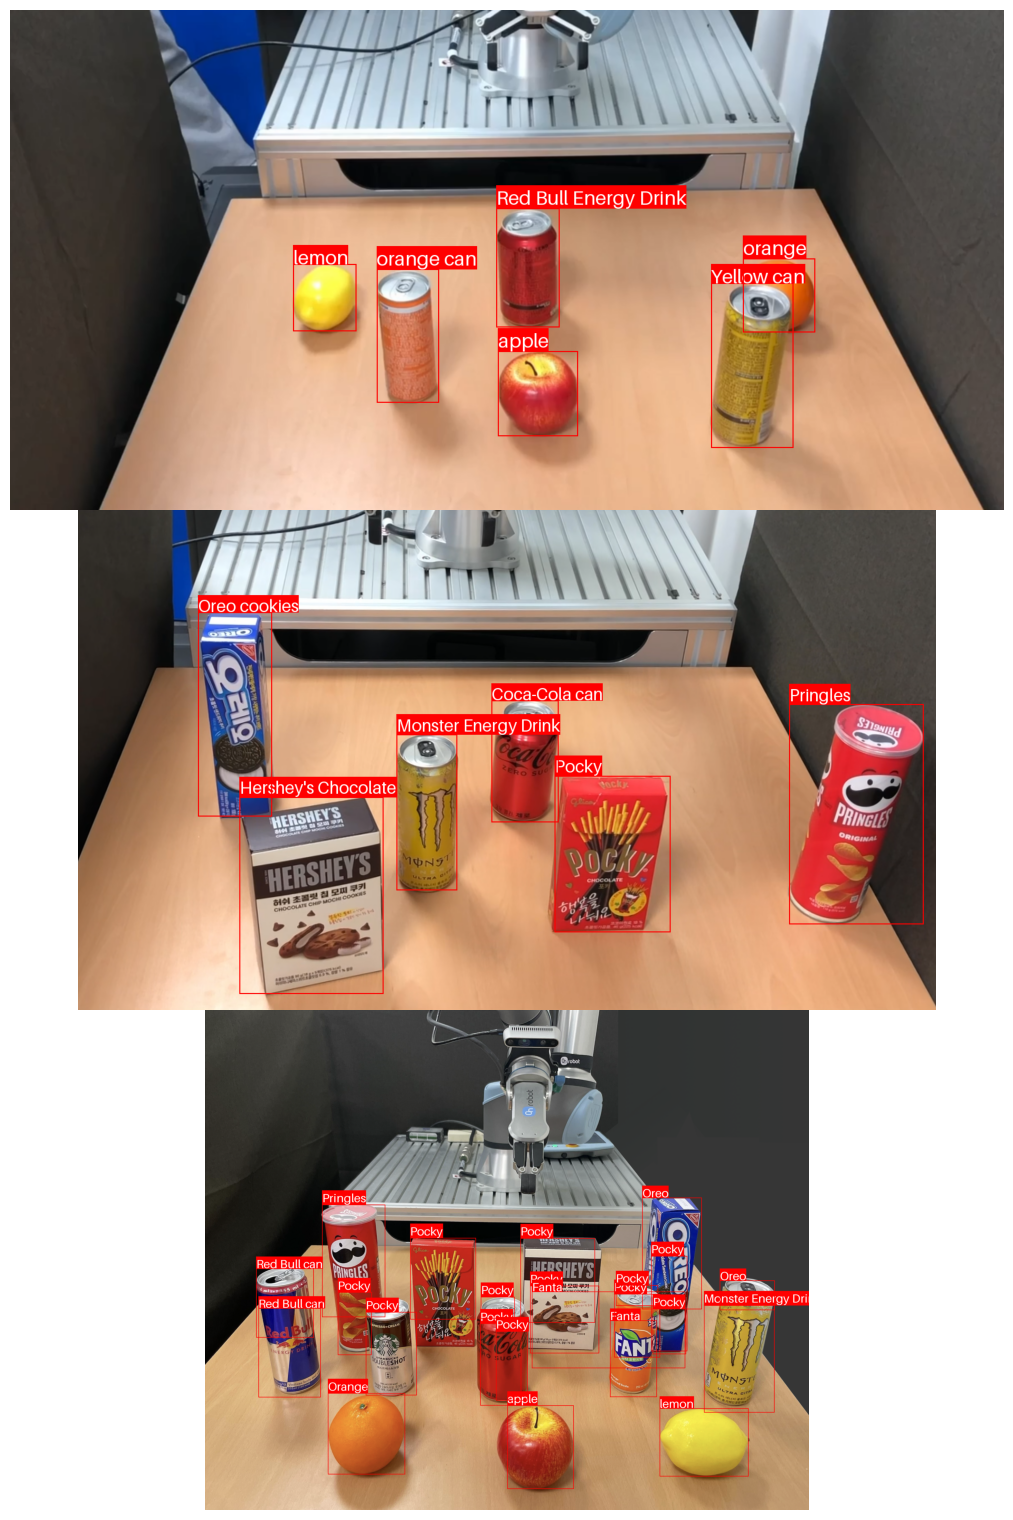

In [15]:
plt.clf()
fig, axs = plt.subplots(len(images), 1, figsize=(10, len(images) * 5))

for ax, img, det_result, response in zip(axs,images, detection_results, responses):

    boxes = det_result['boxes']
    labels = [resp.label for resp in response]

    _img = img.copy()
    label_overlay_img = owlvit.draw_boxes(_img, boxes, labels)

    ax.imshow(label_overlay_img)
    ax.axis('off')

plt.subplots_adjust(hspace=0.1, top=1, bottom=0, left=0, right=1)
plt.tight_layout(pad=0)
plt.show()
